In [1]:
import pandas as pd
import numpy as np
import pm4py
from variant_stats import get_variants_stats
from pm4py.util import ml_utils
import importlib.util
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from sklearn.cluster import SpectralClustering

In [2]:
df2 = pd.read_pickle('decision_paths/subset_optimized_simple_size_0.2_fitnessweights_p0.34_f0.33_c0.33_weightmodel_weight_positive_simplified.pickle')

# Initialize an empty list to hold event log rows
event_log0 = []
event_log1 = []

# Iterate over each decision path in the dataset
timestamp = pd.Timestamp('2024-11-14')
case_id = -1
for i in range(len(df2)):
    data = df2['rule_to_simplified_rules'].iloc[i]
    for path in data:
        case_id += 1
        for t,step in enumerate(path):
            # Create an event dictionary for the current step
            event = {
                'case_id': case_id,
                'activity': step.get('feature_value'),
                'timestamp': timestamp + pd.Timedelta(days=t)
            }
            # if event['activity'] in to_remove:
            #     # print(f" I removed {event['activity']} from the log")
            #     continue
            if pd.isna(event['activity']):
                event['activity'] = f'predict{step['predict']}'

            
            # Append the event to the event log
            if path[-1]['predict'] == 1:
                event_log1.append(event)
            else:
                event_log0.append(event)

event_log1 = pd.DataFrame(event_log1)
event_log0 = pd.DataFrame(event_log0)
log1 = event_log1.copy()
log1.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

log0 = event_log0.copy()
log0.rename(columns={'timestamp': 'time:timestamp', 'case_id': 'case:concept:name', 'activity': 'concept:name'}, inplace=True)

df0 = get_variants_stats(log0)
df1 = get_variants_stats(log1)

In [3]:
df0['sequence']

0      (functstat_90% -minor sx, dhtn2_No-hypertensio...
1      (functstat_100% -no complaints, vintage_0.0-2....
2      (functstat_90% -minor sx, dhtn2_No-hypertensio...
3      (functstat_90% -minor sx, dhtn2_No-hypertensio...
4      (functstat_90% -minor sx, dhtn2_No-hypertensio...
                             ...                        
797    (functstat_100% -no complaints, vintage_0.0-2....
798    (functstat_100% -no complaints, vintage_0.0-2....
799    (functstat_100% -no complaints, vintage_0.0-2....
800    (functstat_100% -no complaints, vintage_0.0-2....
801    (functstat_100% -no complaints, vintage_0.0-2....
Name: sequence, Length: 802, dtype: object

In [4]:
trace_strings = [' '.join(trace) for trace in df0['sequence']]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(trace_strings)  # X is a matrix (n_traces x n_activities)

# Check the shape and feature names
print("TF-IDF Matrix shape:", X.shape)
print("Feature names:", vectorizer.get_feature_names_out())

TF-IDF Matrix shape: (802, 154)
Feature names: ['12' '14' '154' '162' '165' '17' '170' '177' '178' '18' '203' '21' '210'
 '23' '24' '25' '26' '29' '34' '35' '38' '49' '56' '59' '64' '66' '67'
 '68' '69' '71' '79' '82' '83' '84' '88' '90' '92' '96' '99' 'abo_a'
 'abo_a1' 'abo_ab' 'abo_b' 'activity' 'albumin_2' 'albumin_3' 'albumin_4'
 'assist' 'assistance' 'cad' 'can' 'cats_0' 'cats_12' 'cats_17' 'cats_23'
 'cit' 'cod_anoxia' 'cod_cerebrovascular' 'cod_cns' 'cod_head'
 'complaints' 'consid' 'creat_4' 'creat_6' 'creat_7' 'dage_22' 'dage_35'
 'dage_5' 'dage_65' 'dcd_no' 'dcd_yes' 'ddm_neg' 'dhcv_neg' 'dht100_126'
 'dht100_165' 'dht100_170' 'dht100_178' 'dhtn2_no' 'dhtn2_yes' 'disabled'
 'dm' 'do' 'don' 'doncreat_0' 'doncreat_1' 'dwt_19' 'dwt_67' 'dwt_79'
 'dwt_92' 'ecd_0' 'esrddxsimp_diabetes' 'esrddxsimp_gn' 'esrddxsimp_htn'
 'esrddxsimp_other' 'esrddxsimp_pckd' 'functstat_100' 'functstat_30'
 'functstat_40' 'functstat_50' 'functstat_60' 'functstat_70'
 'functstat_80' 'functstat_90' 'hla

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.44it/s]


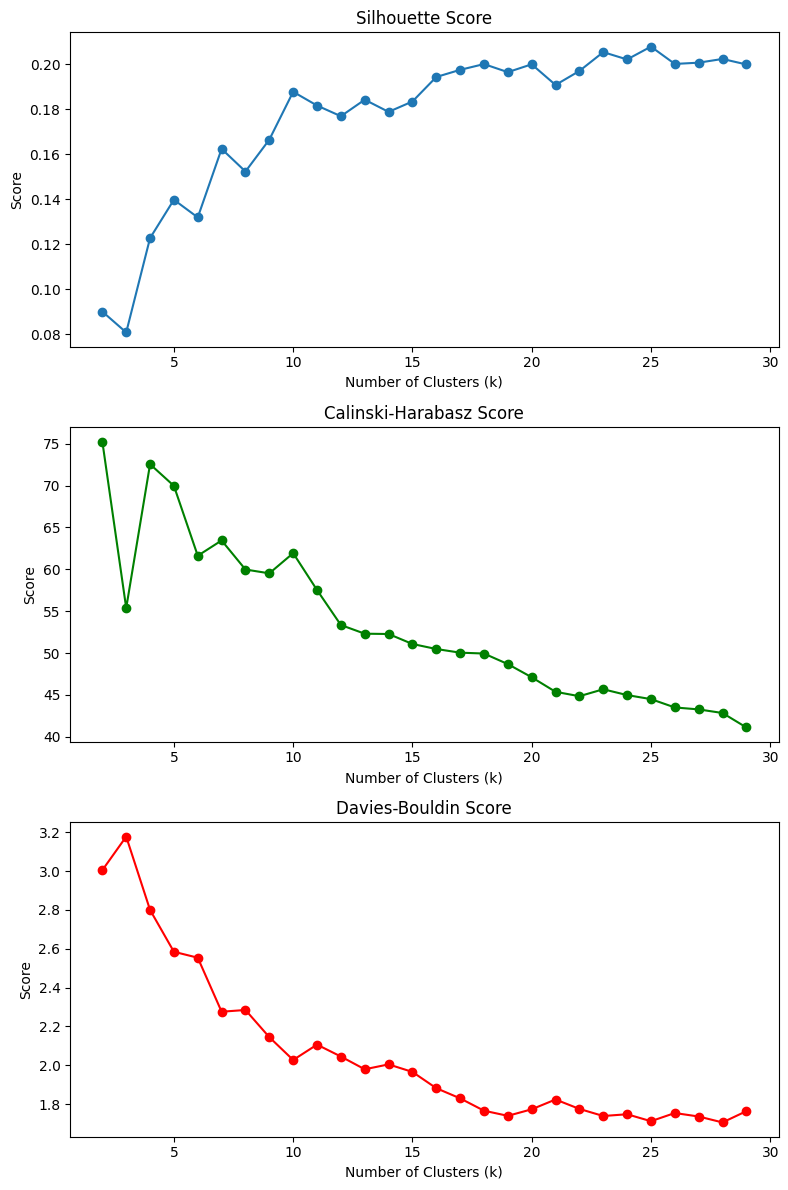

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Store scores for different cluster numbers
k_values = range(2, 30)  # Up to len(traces)-1
silhouette_scores = []
calinski_scores = []
davies_scores = []

# Run KMeans and calculate clustering scores
for k in tqdm(k_values):
    # clustering = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0).fit(X)
    # labels = clustering.labels_
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    silhouette_scores.append(silhouette_score(X, labels))
    calinski_scores.append(calinski_harabasz_score(X.toarray(), labels))
    davies_scores.append(davies_bouldin_score(X.toarray(), labels))

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Silhouette Score
axs[0].plot(k_values, silhouette_scores, marker='o')
axs[0].set_title("Silhouette Score")
axs[0].set_xlabel("Number of Clusters (k)")
axs[0].set_ylabel("Score")

# Calinski-Harabasz Index
axs[1].plot(k_values, calinski_scores, marker='o', color='green')
axs[1].set_title("Calinski-Harabasz Score")
axs[1].set_xlabel("Number of Clusters (k)")
axs[1].set_ylabel("Score")

# Davies-Bouldin Index (lower is better)
axs[2].plot(k_values, davies_scores, marker='o', color='red')
axs[2].set_title("Davies-Bouldin Score")
axs[2].set_xlabel("Number of Clusters (k)")
axs[2].set_ylabel("Score")

plt.tight_layout()
plt.show()


In [7]:
kmeans = SpectralClustering(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X)

In [10]:
numbers = {}
for i in range(len(np.unique(labels))):
    sequences = df0.iloc[labels==i]['sequence']
    print(f'cluster {i} has {len(sequences)}')
    numbers[i] = len(sequences)

cluster 0 has 85
cluster 1 has 40
cluster 2 has 100
cluster 3 has 43
cluster 4 has 144
cluster 5 has 66
cluster 6 has 69
cluster 7 has 137
cluster 8 has 67
cluster 9 has 51


In [11]:
sorted_dict = dict(sorted(numbers.items(), key=lambda item: item[1]))
sorted_dict

{1: 40, 3: 43, 9: 51, 5: 66, 8: 67, 6: 69, 0: 85, 2: 100, 7: 137, 4: 144}

In [12]:
from collections import Counter

sequences = df0.iloc[labels==6]['sequence']
flattened = [item for seq in sequences for item in seq]

# Count occurrences using Counter
count_dict = Counter(flattened)

# Sort the dictionary by value in descending order
sorted_dict = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))

# Print the result
print(sorted_dict)

{'rpvd_No': 69, 'dhtn2_No-hypertension': 69, 'dage_22-34': 69, 'predict0': 69, 'functstat_100% -no complaints': 65, 'DON-RACE-SRTR_WHITE': 63, 'vintage_0.0-2.26': 41, 'ragetx_65.0-66.0': 29, 'vintage_2.26-4.25': 28, 'DON-CAD-DON-COD_HEAD-TRAUMA': 28, 'dhcv_Neg': 27, 'esrddxsimp_HTN': 22, 'ragetx_66.0-69.0': 21, 'ragetx_69.0-71.0': 19, 'dcd_No': 17, 'esrddxsimp_Other': 15, 'esrddxsimp_PCKD': 14, 'esrddxsimp_GN': 14, 'DON-CAD-DON-COD_CEREBROVASCULAR/STROKE': 14, 'dcd_Yes': 5, 'rhtn_No': 5, 'functstat_60% -req assistance': 4, 'rdm2_No-DM': 4, 'DON-RACE-SRTR_ASIAN': 2, 'hlamm_0': 2, 'hlamm_3': 1, 'hlamm_1': 1}


In [72]:
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta

sequences = df0.iloc[labels==5]['sequence']

# Create an empty event log
event_log = EventLog()

# Define base timestamp
base_time = datetime(2024, 1, 1, 0, 0, 0)

# Loop through each sequence
for idx, sequence in enumerate(sequences):
    trace = Trace()
    case_id = f"Case_{idx+1}"
    
    for i, activity in enumerate(sequence):
        event = {
            "case:concept:name": case_id,
            "concept:name": activity,
            "time:timestamp": base_time + timedelta(minutes=i)
        }
        trace.append(event)
    
    event_log.append(trace)
execute_script(event_log)

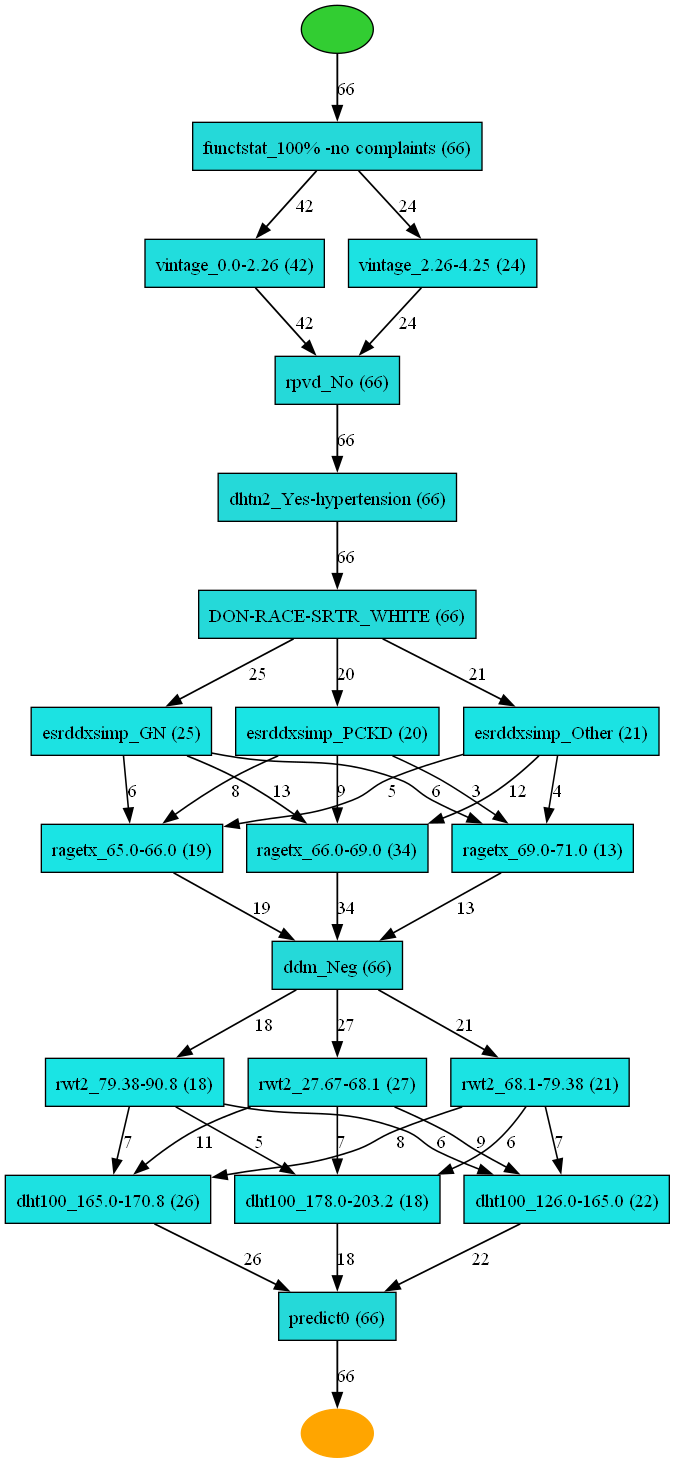

In [73]:
heu_net = heuristics_miner.apply_heu(event_log)

# visualize
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [12]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# Assuming 'df' is your pandas DataFrame with at least:
# 'case:concept:name' (case ID), 'concept:name' (activity), 'time:timestamp' (timestamp)
parameters = {
    log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'
}

log = log_converter.apply(event_log, variant=log_converter.Variants.TO_EVENT_LOG, parameters=parameters)
xes_exporter.apply(log, 'cluster8.xes')


exporting log, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

In [9]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.process_tree import converter as process_tree_converter
def execute_script(log):
    process_tree = inductive_miner.apply(log)
    net, marking, final_marking = process_tree_converter.apply(process_tree)
    metrics = general_evaluation.apply(log, net, marking, final_marking)
    print("metrics=", metrics)

In [69]:
from pm4py.objects.log.obj import EventLog, Trace, Event

# Initialize empty EventLog
converted_log = EventLog()

# Group by case ID (assumes column 'case:concept:name' holds case IDs)
for case_id, group in log0.groupby("case:concept:name"):
    trace = Trace()
    for _, row in group.iterrows():
        event = Event(row.to_dict())
        trace.append(event)
    converted_log.append(trace)

In [70]:
execute_script(converted_log)

replaying log with TBR, completed traces ::   0%|          | 0/802 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2036 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.046272318643888366, 'generalization': 0.8354836503612675, 'simplicity': 0.5365853658536585, 'metricsAverageWeight': 0.6045853337147036, 'fscore': 0.08845176885471577}


In [71]:
for i in range(10):

    sequences = df0.iloc[labels==i]['sequence']
    print(f"label - > {i}*****{i}")
    
    # Create an empty event log
    event_log = EventLog()
    
    # Define base timestamp
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through each sequence
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
        
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
        
        event_log.append(trace)
    execute_script(event_log)

IndexError: Boolean index has wrong length: 802 instead of 1336

In [14]:
from pm4py.objects.log.obj import EventLog, Trace
from datetime import datetime, timedelta
for ix in range(10):
    print(f"###################{ix}#################")
    sequences = df0.iloc[labels==ix]['sequence']
    
    # Create an empty event log
    event_log = EventLog()
    
    # Define base timestamp
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through each sequence
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
        
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
        
        event_log.append(trace)
    execute_script(event_log)

###################0#################


replaying log with TBR, completed traces ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/254 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.15267051459230951, 'generalization': 0.623343515051908, 'simplicity': 0.46153846153846156, 'metricsAverageWeight': 0.5593881227956697, 'fscore': 0.26489879399111355}
###################1#################


replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/141 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.23574368018812464, 'generalization': 0.6042313200114802, 'simplicity': 0.6038647342995168, 'metricsAverageWeight': 0.6109599336247804, 'fscore': 0.3815413891531874}
###################2#################


replaying log with TBR, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/318 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.2804240487946559, 'generalization': 0.781487775517086, 'simplicity': 0.5280898876404494, 'metricsAverageWeight': 0.6475004279880479, 'fscore': 0.4380174662583646}
###################3#################


replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/146 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.6119186046511628, 'generalization': 0.7504825278866853, 'simplicity': 0.6533333333333333, 'metricsAverageWeight': 0.7539336164677953, 'fscore': 0.7592425608656448}
###################4#################


replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/311 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.12726530005941772, 'generalization': 0.703496815390065, 'simplicity': 0.5308641975308642, 'metricsAverageWeight': 0.5904065782450868, 'fscore': 0.22579476198319884}
###################5#################


replaying log with TBR, completed traces ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/155 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.9272727272727272, 'generalization': 0.8145772550783814, 'simplicity': 0.6666666666666666, 'metricsAverageWeight': 0.8521291622544438, 'fscore': 0.9622641509433962}
###################6#################


replaying log with TBR, completed traces ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/263 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.38675651919132725, 'generalization': 0.7183558436016709, 'simplicity': 0.6000000000000001, 'metricsAverageWeight': 0.6762780906982496, 'fscore': 0.5577857595605323}
###################7#################


replaying log with TBR, completed traces ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/461 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.12373102824404458, 'generalization': 0.7374857534210884, 'simplicity': 0.5636363636363636, 'metricsAverageWeight': 0.6062132863253742, 'fscore': 0.22021466905187825}
###################8#################


replaying log with TBR, completed traces ::   0%|          | 0/67 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/245 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.4477396021699819, 'generalization': 0.7944023414501538, 'simplicity': 0.6000000000000001, 'metricsAverageWeight': 0.7105354859050339, 'fscore': 0.6185360979265551}
###################9#################


replaying log with TBR, completed traces ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/97 [00:00<?, ?it/s]

metrics= {'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.6863672182821119, 'generalization': 0.7644620046769961, 'simplicity': 0.6615384615384615, 'metricsAverageWeight': 0.7780919211243923, 'fscore': 0.814018691588785}


In [15]:
import pandas as pd
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation import algorithm as general_evaluation
from pm4py.objects.conversion.process_tree import converter as process_tree_converter

def evaluate_log(log, log_name="log"):
    process_tree = inductive_miner.apply(log)
    net, marking, final_marking = process_tree_converter.apply(process_tree)
    metrics = general_evaluation.apply(log, net, marking, final_marking)

    # Extract and flatten relevant metrics
    result = {
        "log_name": log_name,
        "fitness_perc_fit_traces": metrics["fitness"]["perc_fit_traces"],
        "fitness_avg_trace_fitness": metrics["fitness"]["average_trace_fitness"],
        "fitness_log_fitness": metrics["fitness"]["log_fitness"],
        "fitness_perc_fitting_traces": metrics["fitness"]["percentage_of_fitting_traces"],
        "precision": metrics["precision"],
        "generalization": metrics["generalization"],
        "simplicity": metrics["simplicity"],
        "metricsAverageWeight": metrics["metricsAverageWeight"],
        "fscore": metrics.get("fscore", None)
    }
    return result

# Example: loop over multiple logs
all_results = []

from pm4py.objects.log.importer.xes import importer as xes_importer

for ix in range(10):
    print(f"###################{ix}#################")
    sequences = df0.iloc[labels==ix]['sequence']
    
    # Create an empty event log
    event_log = EventLog()
    
    # Define base timestamp
    base_time = datetime(2024, 1, 1, 0, 0, 0)
    
    # Loop through each sequence
    for idx, sequence in enumerate(sequences):
        trace = Trace()
        case_id = f"Case_{idx+1}"
        
        for i, activity in enumerate(sequence):
            event = {
                "case:concept:name": case_id,
                "concept:name": activity,
                "time:timestamp": base_time + timedelta(minutes=i)
            }
            trace.append(event)
        
        event_log.append(trace)
    metrics = evaluate_log(event_log, log_name=ix)
    all_results.append(metrics)

# Convert to DataFrame
df_results = pd.DataFrame(all_results)
print(df_results)


###################0#################


replaying log with TBR, completed traces ::   0%|          | 0/85 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/254 [00:00<?, ?it/s]

###################1#################


replaying log with TBR, completed traces ::   0%|          | 0/40 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/141 [00:00<?, ?it/s]

###################2#################


replaying log with TBR, completed traces ::   0%|          | 0/100 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/318 [00:00<?, ?it/s]

###################3#################


replaying log with TBR, completed traces ::   0%|          | 0/43 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/146 [00:00<?, ?it/s]

###################4#################


replaying log with TBR, completed traces ::   0%|          | 0/144 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/311 [00:00<?, ?it/s]

###################5#################


replaying log with TBR, completed traces ::   0%|          | 0/66 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/155 [00:00<?, ?it/s]

###################6#################


replaying log with TBR, completed traces ::   0%|          | 0/69 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/263 [00:00<?, ?it/s]

###################7#################


replaying log with TBR, completed traces ::   0%|          | 0/137 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/461 [00:00<?, ?it/s]

###################8#################


replaying log with TBR, completed traces ::   0%|          | 0/67 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/245 [00:00<?, ?it/s]

###################9#################


replaying log with TBR, completed traces ::   0%|          | 0/51 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/97 [00:00<?, ?it/s]

   log_name  fitness_perc_fit_traces  fitness_avg_trace_fitness  \
0         0                    100.0                        1.0   
1         1                    100.0                        1.0   
2         2                    100.0                        1.0   
3         3                    100.0                        1.0   
4         4                    100.0                        1.0   
5         5                    100.0                        1.0   
6         6                    100.0                        1.0   
7         7                    100.0                        1.0   
8         8                    100.0                        1.0   
9         9                    100.0                        1.0   

   fitness_log_fitness  fitness_perc_fitting_traces  precision  \
0                  1.0                        100.0   0.152671   
1                  1.0                        100.0   0.235744   
2                  1.0                        100.0   0.280424  

In [17]:
df_results.to_csv('survived.csv')